# Semi-analytic Normal Mode Solver

The following code calculates the normal modes of N coupled oscillators. Each oscillator is treated as a 1D sphere dipole oscillator.

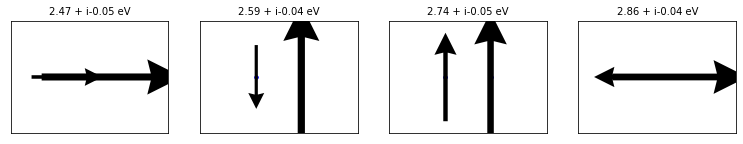

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import yaml
from scipy import optimize

eps_b = 1.0 # dielectric constant of background, (eps_b = 1.0 is vacuum) [unitless]
c = 2.998E+10 # speed of light [cm/s]
hbar_eVs = 6.58212E-16 # Planck's constant [eV*s]
hbar_cgs = 1.0545716E-27 # Planck's constant [cm^2*g/s]
e = 4.80326E-10 # elementary charge, [statC]
prec = 10 # convergence condition for iteration

class CoupledOscillators:
    def __init__(self, num_part, dim, radii, centers): 
        """Defines the different system parameters.
        
        Keyword arguments:
        num_part -- number of particles 
        dim -- dimensions of system (1D or 2D). One osc. per particle per dimension
        radii -- radii of the sphere oscillators
        centers -- particle centers [cm]
        """
        self.num_part = num_part
        self.dim = dim 
        self.radii = radii
        self.centers = centers 
        self.unit_vecs, self.all_centers = self.dipole_orientations()
        self.w0, self.m, self.gamNR = self.dipole_parameters()
        self.mat_size = int(self.dim*self.num_part)

    def dipole_orientations(self):
        """Defines the orientations of each dipole. This function will need to be rewritten
        for a system of nanorods at angles.  
        """
        x_dir = [1,0]
        x_hats = np.tile(x_dir, (self.num_part, 1)) # duplicates x_dir num_part times
        y_dir = [0,1]
        y_hats = np.tile(y_dir, (self.num_part, 1)) 
        all_centers = np.tile(self.centers, (self.num_part,1))
        return np.concatenate((x_hats, y_hats)), all_centers
            
    def dipole_parameters(self):
        """Sets the physical dipole parameters. This is assuming the dipoles represent spheres.
        """
        wp = 9. # bulk plasma frequency [eV]
        eps_inf= 9. # static dielectric response of ionic background [unitless]
        w0_qs = np.sqrt(wp**2/((eps_inf-1)+3)) # quasi-static plasmon resonance frequency [eV]
        v = 4/3*np.pi*(self.radii)**3 # volume of sphere
        m_qs = 4*np.pi*e**2*((9. - 1)+3)/(9*(w0_qs/hbar_eVs)**2*v) # quasi-staticc mass of sphere
        # Long wavelength approximation (https://www.osapublishing.org/josab/viewmedia.cfm?uri=josab-26-3-517&seq=0)
        m =  m_qs + e**2/(self.radii*c**2) # mass with radiation damping
        w0 = w0_qs*np.sqrt(m_qs/m) # plasmon resonance frequency with radiation damping
        gamNR = 0.07 * m_qs/m # adjusted nonradiative damping 
        return w0, m, gamNR
    
    def coupling(self, dip_i, dip_j, k): 
        """Calculates the off diagonal matrix elements, which is the 
        coupling between the ith and jth dipole divided by the effective 
        mass of the ith dipole.
        
        Keyword arguments:
        dip_i -- ith dipole
        dip_j -- jth dipole
        k -- wave vector [cm]
        """
        k = np.real(k) 
        r_ij = self.all_centers[dip_i,:] - self.all_centers[dip_j,:] # distance between ith and jth dipole 
        mag_rij = np.linalg.norm(r_ij) 
        if mag_rij == 0: 
        #I f i and j are at the same location, the coupling (g) is zero (prevents a divide by zero error.)
            g=0
        else:
            nhat_ij = r_ij / mag_rij # unit vector in r_ij direction.
            xi_hat = self.unit_vecs[dip_i] # unit vector of the ith dipole
            xj_hat = self.unit_vecs[dip_j] # unit vector of the jth dipole
            xi_dot_nn_dot_xj = np.dot(xi_hat, nhat_ij)*np.dot(nhat_ij, xj_hat) 
            nearField = ( 3.*xi_dot_nn_dot_xj - np.dot(xi_hat,xj_hat) ) / mag_rij**3 # near field coupling.
            intermedField = 1j*k*(3*xi_dot_nn_dot_xj - np.dot(xi_hat,xj_hat)) / mag_rij**2 # intermediate field coupling
            farField = k**2*(xi_dot_nn_dot_xj - np.dot(xi_hat,xj_hat)) / mag_rij # far field coupling
            g =  e**2 * hbar_eVs**2 * ( nearField - intermedField - farField ) * np.exp(1j*k*mag_rij) #total, radiative coupling
        return -g/(self.m[dip_i]) 
    
    def make_matrix(self, k):
        """Forms the matrix A for A(w)*x = w^2*x. 
        
        Keywords: 
        k -- wave vector [cm]
        """
        matrix = np.zeros( (self.mat_size, self.mat_size) ,dtype=complex) 
        w_guess = k*c/np.sqrt(eps_b)*hbar_eVs # Left-hand size w [eV]
        gam = self.gamNR + (np.real(w_guess))**2*(2.0*e**2)/(3.0*self.m*c**3)/hbar_eVs # radiative damping for dipole i
        matrix[( np.arange(self.mat_size), np.arange(self.mat_size) )] = self.w0**2 - 1j*gam*w_guess # on-diagonal matrix elements
        for dip_i in range(0 , self.mat_size): 
            for dip_j in range(0, self.mat_size): 
                    if dip_i != dip_j:
                        matrix[ dip_i, dip_j] = self.coupling(dip_i=dip_i, dip_j=dip_j, k=k) # off-diagonal matrix elements
            eigval, eigvec = np.linalg.eig(matrix)
        return eigval, eigvec, matrix

    def iterate(self):
        """Solves A(w)*x = w^2*x for w and x. This is done by guessing the first left-side w, calculating
        eigenvalues (w^2) and eigenvectors (x) of A(w), then comparing the initial guess w to the calculated w.
        If the difference of those values is less than the variable precision, use the new w and continue the 
        cycle. The code will stop (converge), when the both w agree as well as the eigenvectors, x. Note that if
        the while loop surpasses 100 trials for a single eigenvalue/eigenvector set, the selection of the left-hand
        side w is modified to take into account previous trials. 
        """
        final_eigvals = np.zeros(self.mat_size,dtype=complex) 
        final_eigvecs = np.zeros( (self.mat_size, self.mat_size), dtype=complex) 
        w_init = -1j*self.gamNR/2. + np.sqrt(-self.gamNR**2/4.+self.w0**2) # Initial guess of left-hand size w. This is the result for an isolated nonradiative dipole.
        for mode in range(0,self.mat_size): # Converge each mode individually.
            eigval_hist = np.array([w_init[mode], w_init[mode]*1.1],dtype=complex) 
            eigvec_hist = np.zeros((self.mat_size, 2))
            count = 0
            while (np.abs((np.real(eigval_hist[0]) - np.real(eigval_hist[1])))  > 10**(-prec)) or \
                  (np.abs((np.imag(eigval_hist[0]) - np.imag(eigval_hist[1]))) > 10**(-prec)) or \
                  (np.sum(np.abs((eigvec_hist[:,0] - eigvec_hist[:,1]))) > 10**(-prec)):
                w_guess = eigval_hist[0]
                if count > 100: 
                    denom = ( eigval_hist[2] - eigval_hist[1] ) - ( eigval_hist[1] - eigval_hist[0] )
                    w_guess = eigval_hist[2] - ( eigval_hist[2] - eigval_hist[1] )**2 / denom 
                k = w_guess/hbar_eVs*np.sqrt(eps_b)/c
                val, vec, H = self.make_matrix(k=k)
                amp = np.sqrt(np.abs(val))
                phi = np.arctan2(np.imag(val), np.real(val))
                energy = amp*(np.cos(phi/2)+1j*np.sin(phi/2))
                post_sort_val = energy[energy.argsort()] # sort the evals and evecs so that we are comparing the same eval/evec as the previous trial.
                post_sort_vec = vec[:,energy.argsort()]
                this_val = post_sort_val[mode]
                this_vec = post_sort_vec[:,mode]
                eigval_hist = np.append(this_val, eigval_hist)
                eigvec_hist = np.column_stack((this_vec, eigvec_hist))
                #print(mode, this_val)
                count = count + 1                 
            final_eigvals[mode] = eigval_hist[0]
            final_eigvecs[:,mode] = eigvec_hist[:,0]
        return final_eigvals, final_eigvecs  
    
    def see_vectors(self):
        """Plot the convereged eigenvectors."""
        final_eigvals, final_eigvecs = self.iterate()
        dip_ycoords = self.all_centers[:,0]
        dip_zcoords = self.all_centers[:,1]  
        plt.figure(1, figsize=[13,5])
        for mode in range(0,self.mat_size):
            w = final_eigvals[mode]
            v = np.real(final_eigvecs[:,mode])
            plt.subplot(1,self.mat_size,mode+1)
            ax = plt.gca()
            ax.set_aspect('equal', adjustable='box')
            plt.title('%.2f' % (np.real(w)) + ' + i%.2f eV' % (np.imag(w)), fontsize=10)
            plt.scatter(dip_ycoords, dip_zcoords,c='blue',s=10)
            p = v[...,np.newaxis]*self.unit_vecs
            p_perpart = p[:int(self.mat_size/2),:] + p[int(self.mat_size/2):,:] 

            ymin = min(dip_ycoords)-50E-7; ymax = max(dip_ycoords)+50E-7
            zmin = min(dip_zcoords)-50E-7; zmax = max(dip_zcoords)+50E-7
            plt.quiver(dip_ycoords[:int(self.mat_size/2)], dip_zcoords[:int(self.mat_size/2)], p_perpart[:,0], p_perpart[:,1], pivot='mid', 
                width=.5, #shaft width in arrow units 
                scale=1., 
                headlength=5,
                headwidth=5.,
                minshaft=4., 
                minlength=.1
                )
            plt.xlim([ymin, ymax])
            plt.ylim([zmin, zmax])
            plt.yticks([]); plt.xticks([])

rod_heterodimer = CoupledOscillators(
        2, # num particles
        2, # num dimensions 
        np.array([20E-7, 30E-7, 20E-7, 30E-7]), #radii (if isotropic, [r1, r2, r1, r2])
        np.array([[-20E-7, 0], [20E-7, 0]]), # particle centers [particle 1, particle 2, ...]
        )

single_rhombus = CoupledOscillators(
        4, # num particles
        2, # num dimensions 
        np.array([75.E-7, 75.E-7, 87.E-7, 87.E-7, 122.E-7,122.E-7,70.E-7, 70.E-7]), #radii (if isotropic, [r1, r2, r1, r2])
        np.array([[0, 103.E-7], [0, -103.E-7], [-49.5E-7, 0], [49.5E-7, 0]]), # particle centers
        )
rod_heterodimer.see_vectors()
